# Деревья решений 
В этом задании предстоит реализовать очень полезный метод классификации - дерево решений. 

Одной из его особенностей является возможность объяснить в человекочитаемой форме, почему мы отнесли объект к определенному классу. Эта особенность позволяет использовать деревья решений для создания систем, которые могут подсказывать специалистам, на что именно стоит обратить внимание при принятии решений. Кроме того, этот метод часто используется в случаях, когда интерпретируемость модели имеет большое значение, например, в чувствительных задачах 

In [1]:
import numpy as np
import pandas
import random
import matplotlib.pyplot as plt
import matplotlib

Основная идея любого алгоритма дерева решений заключается в следующем: 
1. Выберите лучший атрибут, используя меры выбора атрибута (ASM), чтобы разделить примеры. 
2.  Сделайте этот атрибут узлом решения и разбейте набор данных на более мелкие подмножества. 
3. Начните построение дерева, рекурсивно повторяя этот процесс для каждого дочернего элемента, пока не совпадет одно из условий:
   1. Все кортежи принадлежат одному и тому же значению атрибута. 
   2. Оставшихся атрибутов больше нет. 
   3. Больше нет примеров

## Использование различных моделей

Протестируем решение на датасетах [mushrooms](https://www.kaggle.com/datasets/uciml/mushroom-classification) и diabetes?.
1. Выполним загрузку и предобработку данных.
2. Разобьем данные на тренировочный и валидационный набор для оценки точности работы алгоритма.
3. Посчитаем метрики для различных параметров построения дерева

In [2]:
from sklearn.metrics import accuracy_score, recall_score, precision_score
import yaml
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [14]:
with open('../config.yaml', 'r') as f:
    cfg = yaml.safe_load(f)

In [4]:
df = pd.read_csv(cfg["classification"]["dataset"])

In [5]:
df = df.drop(['id', 'Unnamed: 32'], axis=1)
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [6]:
df['diagnosis'] = df['diagnosis'].replace({'B': 0, 'M': 1}).astype(int)
target = 'diagnosis'
features = list(df.columns)
features.remove('diagnosis')
features

['radius_mean',
 'texture_mean',
 'perimeter_mean',
 'area_mean',
 'smoothness_mean',
 'compactness_mean',
 'concavity_mean',
 'concave points_mean',
 'symmetry_mean',
 'fractal_dimension_mean',
 'radius_se',
 'texture_se',
 'perimeter_se',
 'area_se',
 'smoothness_se',
 'compactness_se',
 'concavity_se',
 'concave points_se',
 'symmetry_se',
 'fractal_dimension_se',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'smoothness_worst',
 'compactness_worst',
 'concavity_worst',
 'concave points_worst',
 'symmetry_worst',
 'fractal_dimension_worst']

In [7]:
X_diagnosis = df[features]
y_diagnosis = df[[target]]

In [20]:
df = pd.read_csv(cfg["classification"]["mushrooms"])
target = 'class'
features = list(df.columns)
features.remove(target)
features
X_mushroom = df[features]
y_mushroom = df[[target]]

In [21]:
class MultiColumnEncoder:
    def __init__(self, columns=None):
        self.columns = columns
        
    def fit_transform(self, X):
        train=X.copy()
        if self.columns is not None:
            for col in self.columns:
                train[col]=ce.CountEncoder().fit_transform(train[col])
        else:
            for col in X.columns:
                train[col]=ce.CountEncoder().fit_transform(train[col])
        return train      

In [22]:
import category_encoders as ce

encoder = MultiColumnEncoder()

X_mushroom = encoder.fit_transform(df)

In [23]:
X_mushroom.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,3916,3656,2556,2284,3376,256,7914,6812,2512,408,...,4936,4464,4384,8124,7924,7488,3968,1872,1248,368
1,4208,3656,2556,1072,3376,400,7914,6812,5612,408,...,4936,4464,4384,8124,7924,7488,3968,1968,400,2148
2,4208,452,2556,1040,3376,400,7914,6812,5612,1048,...,4936,4464,4384,8124,7924,7488,3968,1968,400,292
3,3916,3656,3244,1040,3376,256,7914,6812,2512,1048,...,4936,4464,4384,8124,7924,7488,3968,1872,1248,368
4,4208,3656,2556,1840,4748,3528,7914,1312,5612,408,...,4936,4464,4384,8124,7924,7488,2776,1968,384,2148


In [24]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_mushroom = encoder.fit_transform(y_mushroom)

D:\Anaconda\envs\students\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_diagnosis, y_diagnosis, test_size=0.2, random_state=1)

In [26]:
y_train

,diagnosis
408,1
4,1
307,0
386,0
404,0
...,...
129,1
144,0
72,1
235,0


Поэкспериментируем с деревом решений из библиотеки sklearn. 

In [15]:
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)

In [16]:
tree.predict_proba(X_test)[:, 1]

array([0.83333333, 0.26666667, 0.        , 0.4375    , 0.4375    ,
       1.        , 1.        , 1.        , 0.        , 0.03333333,
       0.        , 0.83333333, 1.        , 0.        , 0.4375    ,
       0.03333333, 0.        , 0.        , 0.26666667, 1.        ,
       0.        , 0.        , 1.        , 0.        , 0.83333333,
       0.26666667, 0.03333333, 1.        , 1.        , 0.4375    ,
       1.        , 0.        , 1.        , 0.83333333, 0.        ,
       0.        , 0.4375    , 0.        , 0.26666667, 0.        ,
       0.        , 0.26666667, 0.03333333, 0.        , 0.03333333,
       0.83333333, 0.        , 0.        , 0.        , 1.        ,
       1.        , 1.        , 0.03333333, 0.        , 0.        ,
       0.        , 0.        , 0.4375    , 0.        , 0.        ,
       0.        , 0.26666667, 0.83333333, 0.        , 0.        ,
       0.03333333, 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.     

In [17]:
metrics.roc_auc_score(y_test, tree.predict_proba(X_test)[:, 1])

0.9305555555555556

[Text(0.5, 0.875, 'x[22] <= 106.05\ngini = 0.468\nsamples = 455\nvalue = [285, 170]'),
 Text(0.3, 0.625, 'x[27] <= 0.117\ngini = 0.064\nsamples = 271\nvalue = [262, 9]'),
 Text(0.2, 0.375, 'x[7] <= 0.034\ngini = 0.008\nsamples = 241\nvalue = [240, 1]'),
 Text(0.1, 0.125, 'gini = 0.0\nsamples = 211\nvalue = [211, 0]'),
 Text(0.3, 0.125, 'gini = 0.064\nsamples = 30\nvalue = [29, 1]'),
 Text(0.4, 0.375, 'gini = 0.391\nsamples = 30\nvalue = [22, 8]'),
 Text(0.7, 0.625, 'x[6] <= 0.086\ngini = 0.219\nsamples = 184\nvalue = [23, 161]'),
 Text(0.6, 0.375, 'gini = 0.492\nsamples = 32\nvalue = [18, 14]'),
 Text(0.8, 0.375, 'x[23] <= 957.3\ngini = 0.064\nsamples = 152\nvalue = [5, 147]'),
 Text(0.7, 0.125, 'gini = 0.278\nsamples = 30\nvalue = [5, 25]'),
 Text(0.9, 0.125, 'gini = 0.0\nsamples = 122\nvalue = [0, 122]')]

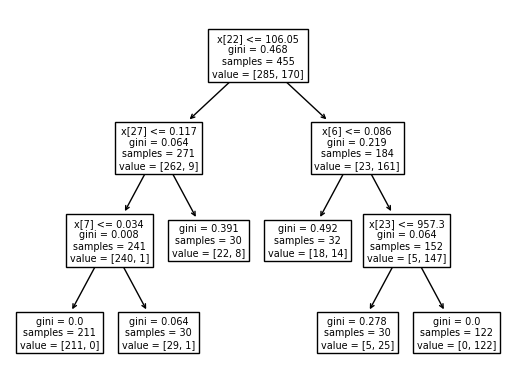

In [18]:
plot_tree(tree)

In [19]:
tree_gini = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=0)

# fit the model
tree_gini.fit(X_train, y_train)
y_pred_gini = tree_gini.predict(X_test)

[Text(0.5, 0.875, 'x[22] <= 106.05\ngini = 0.468\nsamples = 455\nvalue = [285, 170]'),
 Text(0.25, 0.625, 'x[27] <= 0.159\ngini = 0.064\nsamples = 271\nvalue = [262, 9]'),
 Text(0.125, 0.375, 'x[27] <= 0.135\ngini = 0.03\nsamples = 265\nvalue = [261, 4]'),
 Text(0.0625, 0.125, 'gini = 0.008\nsamples = 254\nvalue = [253, 1]'),
 Text(0.1875, 0.125, 'gini = 0.397\nsamples = 11\nvalue = [8, 3]'),
 Text(0.375, 0.375, 'x[1] <= 16.22\ngini = 0.278\nsamples = 6\nvalue = [1, 5]'),
 Text(0.3125, 0.125, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.4375, 0.125, 'gini = 0.0\nsamples = 5\nvalue = [0, 5]'),
 Text(0.75, 0.625, 'x[21] <= 20.645\ngini = 0.219\nsamples = 184\nvalue = [23, 161]'),
 Text(0.625, 0.375, 'x[22] <= 116.8\ngini = 0.388\nsamples = 19\nvalue = [14, 5]'),
 Text(0.5625, 0.125, 'gini = 0.0\nsamples = 13\nvalue = [13, 0]'),
 Text(0.6875, 0.125, 'gini = 0.278\nsamples = 6\nvalue = [1, 5]'),
 Text(0.875, 0.375, 'x[7] <= 0.049\ngini = 0.103\nsamples = 165\nvalue = [9, 156]'),
 Te

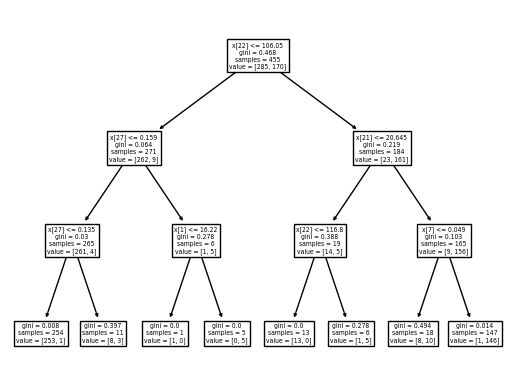

In [20]:
plot_tree(tree_gini.fit(X_train, y_train)) 

In [21]:
metrics.roc_auc_score(y_test, tree_gini.predict_proba(X_test)[:, 1])

0.9231150793650793

In [22]:
y_pred_train_gini = tree_gini.predict(X_train)
print('Model accuracy score with criterion gini index: {0:0.4f}'. format(accuracy_score(y_test, y_pred_gini)))
#Accuracy Score for training set
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train_gini)))

Model accuracy score with criterion gini index: 0.9123
Training-set accuracy score: 0.9692


Model accuracy score with criterion entropy: 0.9123
Training-set accuracy score: 0.9648


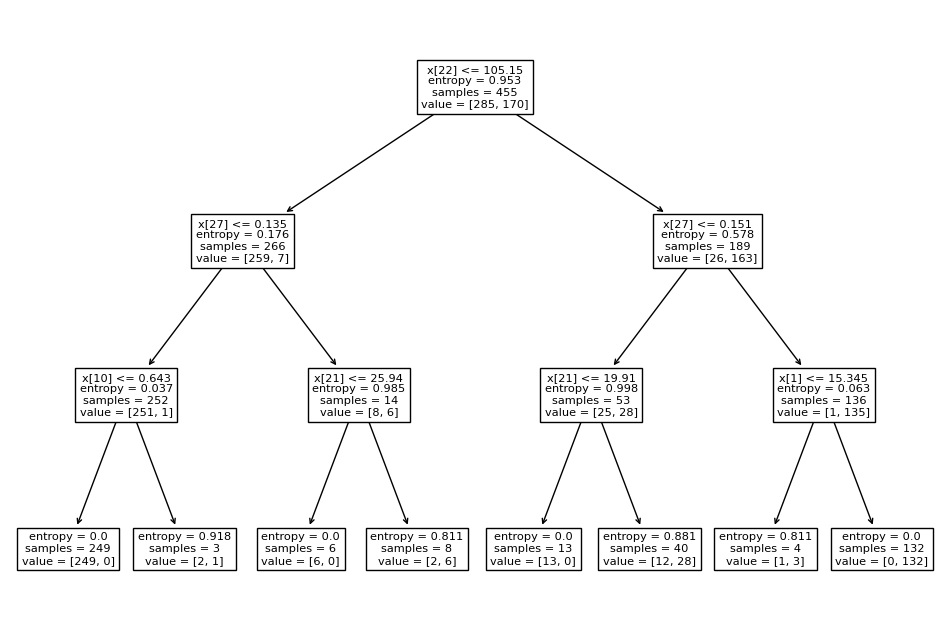

In [23]:
tree_en = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
# fit the model
tree_en.fit(X_train, y_train)
plt.figure(figsize=(12,8))
plot_tree(tree_en.fit(X_train, y_train)) 
y_pred_en = tree_en.predict(X_test)
y_pred_train_en = tree_en.predict(X_train)
print('Model accuracy score with criterion entropy: {0:0.4f}'. format(accuracy_score(y_test, y_pred_en)))
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train_en)))

In [24]:
print('Training set score: {:.4f}'.format(tree_en.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(tree_en.score(X_test, y_test)))

Training set score: 0.9648
Test set score: 0.9123


[Text(0.5, 0.75, 'x[0] <= 4062.0\ngini = 0.499\nsamples = 6499\nvalue = [3388, 3111]'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 3111\nvalue = [0, 3111]'),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 3388\nvalue = [3388, 0]')]

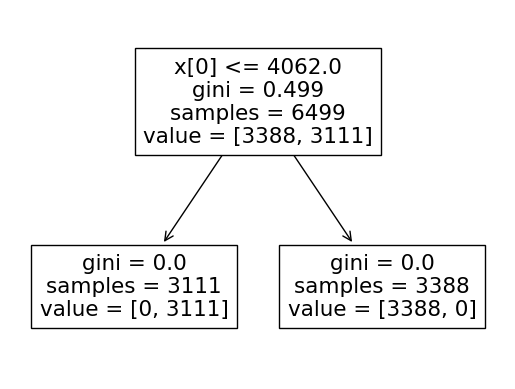

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_mushroom, y_mushroom, test_size=0.2, random_state=1)
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
tree.fit(X_train, y_train)
plot_tree(tree)

In [31]:
y_pred_train = tree.predict(X_train)
y_pred_test = tree.predict(X_test)
print('Model accuracy score with criterion gini index: {0:0.4f}'. format(accuracy_score(y_test, y_pred_test)))
#Accuracy Score for training set
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Model accuracy score with criterion gini index: 1.0000
Training-set accuracy score: 1.0000


Сравним, как разные классификаторы строят границы разделения

In [35]:
classifiers = {
    "RF_basic_3": DecisionTreeClassifier(max_depth=3),
    "RF_basic_5_no_min": DecisionTreeClassifier(max_depth=5),
    "RF_basic_5": DecisionTreeClassifier(max_depth=5, min_samples_leaf=30),
    "RF_gini_3": DecisionTreeClassifier(max_depth=3, criterion='gini',  min_samples_leaf=30),
    "RF_gini_5": DecisionTreeClassifier(max_depth=5, criterion='gini', min_samples_leaf=30),
    "RF_entropy_3": DecisionTreeClassifier(max_depth=3, criterion='entropy', min_samples_leaf=30),
    "RF_entropy_5": DecisionTreeClassifier(max_depth=5, criterion='entropy', min_samples_leaf=30),
    "RF_entropy_5_no_min": DecisionTreeClassifier(max_depth=5, criterion='entropy'),
}
    

columns =  X_diagnosis.columns[:2] 
columns_mushroom = ['gill-color', 'cap-color']

datasets = [
    (X_diagnosis[columns].to_numpy(), y_diagnosis.to_numpy()),
    (X_mushroom[columns_mushroom].to_numpy(), y_mushroom),
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1)
]


In [36]:
def set_grid(ax, i, j, x_min, x_max, y_min, y_max):
    ax[i][j].set_xlim(x_min, x_max)
    ax[i][j].set_ylim(y_min, y_max)
    ax[i][j].set_xticks(())
    ax[i][j].set_yticks(())

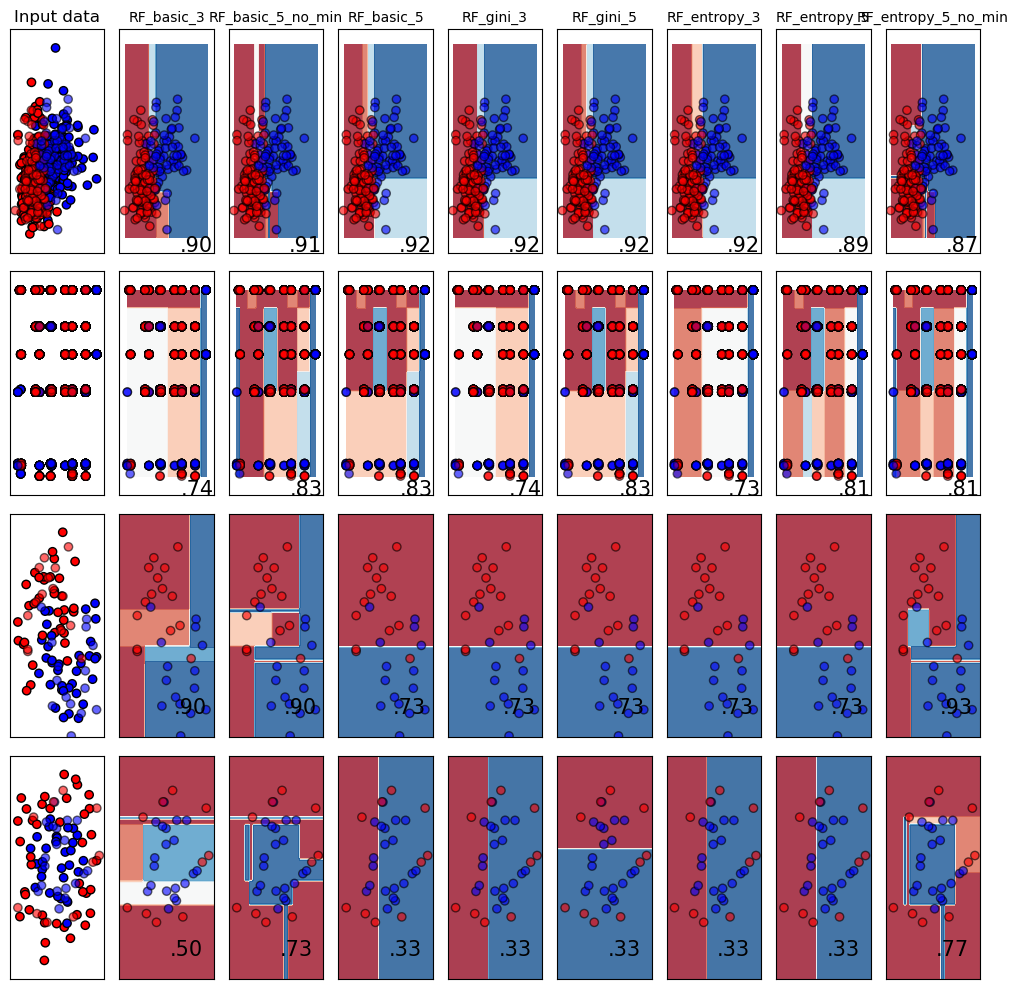

In [39]:
fig, ax = plt.subplots(len(datasets), len(classifiers)+1, figsize=(10, 10))

for dataset_num, data in enumerate(datasets):
    X, y = data
    X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.3, random_state=42
      )
    diff_x = X_train[:, 0].max() - X_train[:, 0].min()
    diff_y = X_train[:, 1].max() - X_train[:, 1].min()
    x_min, x_max = X_train[:, 0].min() - diff_x*0.1, X_train[:, 0].max() + diff_x*0.1
    y_min, y_max = X_train[:, 1].min() - diff_y*0.1, X_train[:, 1].max() + diff_y*0.1


    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    if dataset_num == 0:
          ax[dataset_num][0].set_title("Input data")
            
    # Plot the training points
    ax[dataset_num][0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax[dataset_num][0].scatter(
      X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    set_grid(ax, dataset_num, 0, x_min, x_max, y_min, y_max)
    
    # iterate over classifiers
    for cls_num, (name, clf) in enumerate(classifiers.items(), start=1):
        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        DecisionBoundaryDisplay.from_estimator(
            clf, X_train, cmap=cm, alpha=0.8, ax=ax[dataset_num][cls_num], eps=0.5
        )
        
        # Plot the training points
        #ax[dataset_num][cls_num].scatter(
        #    X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        #)
        
        # Plot the testing points
        ax[dataset_num][cls_num].scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        set_grid(ax, dataset_num, cls_num, x_min, x_max, y_min, y_max)
        if dataset_num == 0:
            ax[dataset_num][cls_num].set_title(name, fontdict={'fontsize': 10, 'fontweight': 'medium'})
            
        ax[dataset_num][cls_num].text(
            x_max - 0.3,
            y_min + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )

plt.tight_layout()
plt.show()